In [11]:
import pickle
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
with open("migration_graph.gpickle", "rb") as f:
    G = pickle.load(f)

with open("migration_data.pkl", "rb") as f:
    data = pickle.load(f)
key_nodes_df = data["key_nodes_df"]
edges_df = data["edges_df"]
temporal_changes = data["temporal_changes"]

## Higher Order Properties

In [3]:
# --- Reciprocity ---

# Overall reciprocity of the directed migration graph
overall_recip = nx.reciprocity(G)
print(f"Overall reciprocity: {overall_recip:.3f}")

# Node-level reciprocity (for key nodes only, if you like)
node_recip = nx.reciprocity(G, nodes=key_nodes_df['cluster_id'].tolist())
print("\nSample node reciprocity (first 10):")
for nid, r in list(node_recip.items())[:10]:
    print(f"  node {nid}: {r:.3f}" if r is not None else f"  node {nid}: None (isolated)")

# --- Assortativity ---

# 1) Degree assortativity (how similar degrees are along edges)
deg_assort = nx.degree_assortativity_coefficient(G, x='out', y='in', weight='Weight')
print(f"\nDegree assortativity (out-degree vs in-degree, weighted): {deg_assort:.3f}")

# 2) Attribute assortativity by state (or region)
# Make sure 'state' (or whatever you used) is a node attribute
# e.g., nx.set_node_attributes(G, dict(zip(key_nodes_df['cluster_id'], key_nodes_df['state'])), 'state')
attr_assort_state = nx.attribute_assortativity_coefficient(G, 'state')
print(f"Attribute assortativity by state: {attr_assort_state:.3f}")

# 3) Optional: numeric assortativity by latitude/longitude
# (requires lat/lon stored as node attributes)
lat_assort = nx.numeric_assortativity_coefficient(G, 'lat')
lon_assort = nx.numeric_assortativity_coefficient(G, 'lon')
print(f"Numeric assortativity by latitude: {lat_assort:.3f}")
print(f"Numeric assortativity by longitude: {lon_assort:.3f}")


Overall reciprocity: 0.004

Sample node reciprocity (first 10):
  node 50: 0.000
  node 140: 0.000
  node 243: 0.000
  node 38: 0.000
  node 119: 0.000
  node 67: 0.000
  node 115: 0.000
  node 51: 0.000
  node 333: 0.000
  node 53: 0.000

Degree assortativity (out-degree vs in-degree, weighted): 0.407
Attribute assortativity by state: nan


c:\Users\fraia\Environments\Network Science\venv\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)


Numeric assortativity by latitude: 0.878
Numeric assortativity by longitude: 0.120


The overal reciprocity of the network is 0.4 % so our migration netowork is mostly one sided.
 Degree assortativity of about 0.41 indicates moderate positive assortativity, so high‑degree stopover hubs tend to connect to other high‑degree hubs, forming a relatively cohesive “core” of heavily used sites

## Temporal Analysis

In [17]:
import pandas as pd
import networkx as nx
import numpy as np
 # For progress tracking

def analyze_evolution_bootstrap(edges_df, cluster_nodes, start_year=2016, n_iterations=100):
    edge_year_flat = edges_df.explode('years').rename(columns={'years': 'year'})
    edge_year_flat = edge_year_flat[edge_year_flat['year'] >= start_year]
    
    yearly_counts = edge_year_flat.groupby('year').size()
    min_edges = yearly_counts.min()
    
    results = []
    all_years = sorted(edge_year_flat['year'].unique())

    for year in all_years:
        year_pool = edge_year_flat[edge_year_flat['year'] == year]
        
        # Lists to store metrics for bootstrap iterations
        it_diameters = []
        it_paths = []
        it_90th_paths = []
        it_lwcc_size = []

        print(f"Bootstrapping Year {year}...")
        for i in range(n_iterations):
            # 1. Bootstrap: Sample with replacement (or without if you prefer rarefaction)
            sub_edges = year_pool.sample(n=min_edges, replace=True)
            
            G = nx.DiGraph()
            G.add_edges_from(zip(sub_edges['source'], sub_edges['target']))
            
            if G.number_of_edges() > 0:
                # 2. Extract LWCC and size
                lwcc_nodes = max(nx.weakly_connected_components(G), key=len)
                lwcc_ratio = len(lwcc_nodes) / cluster_nodes.shape[0]
                it_lwcc_size.append(lwcc_ratio)
                
                # 3. Path calculations (Undirected for diameter/90th)
                subgraph = G.subgraph(lwcc_nodes).copy()
                
                # All shortest path lengths
                path_lengths = []
                spl = dict(nx.all_pairs_shortest_path_length(subgraph))
                for source in spl:
                    for target in spl[source]:
                        if source != target:
                            path_lengths.append(spl[source][target])
                
                if path_lengths:
                    it_diameters.append(max(path_lengths))
                    it_paths.append(np.mean(path_lengths))
                    it_90th_paths.append(np.percentile(path_lengths, 90))
            
        results.append({
            'year': year,
            'diam_mean': np.mean(it_diameters),
            'diam_std': np.std(it_diameters),
            'path_mean': np.mean(it_paths),
            'path_std': np.std(it_paths),
            'path_90th_mean': np.mean(it_90th_paths),
            'lwcc_size_mean': np.mean(it_lwcc_size)
        })

    return pd.DataFrame(results)

bootstrap_df = analyze_evolution_bootstrap(edges_df, key_nodes_df)
print(bootstrap_df)

Bootstrapping Year 2016...
Bootstrapping Year 2017...
Bootstrapping Year 2018...
Bootstrapping Year 2019...
Bootstrapping Year 2020...
Bootstrapping Year 2021...
Bootstrapping Year 2022...
Bootstrapping Year 2023...
Bootstrapping Year 2024...
Bootstrapping Year 2025...
   year  diam_mean  diam_std  path_mean  path_std  path_90th_mean  \
0  2016       4.69  1.083467   2.230000  0.361156           3.691   
1  2017       4.59  1.312212   2.196667  0.437404           3.621   
2  2018       4.38  1.247237   2.126667  0.415746           3.466   
3  2019       4.17  0.679043   2.056667  0.226348           3.301   
4  2020       4.92  1.547126   2.306667  0.515709           3.899   
5  2021       4.97  1.615271   2.323333  0.538424           3.917   
6  2022       4.54  1.195157   2.180000  0.398386           3.617   
7  2023       4.92  1.293677   2.306667  0.431226           3.917   
8  2024       4.47  1.152866   2.156667  0.384289           3.583   
9  2025       4.46  1.211776   2.153333 

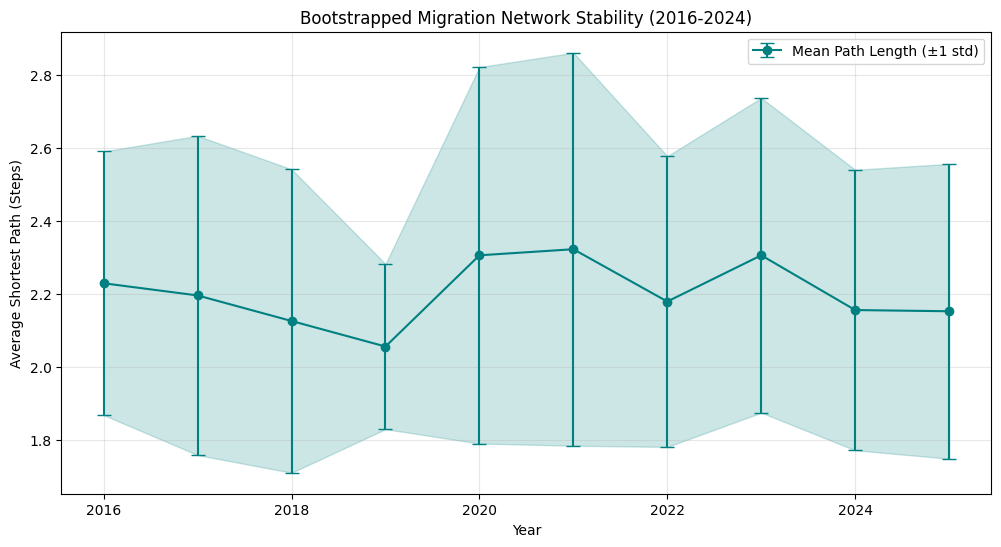

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotting Path Mean with Standard Deviation as a shaded area
plt.errorbar(bootstrap_df['year'], bootstrap_df['path_mean'], 
             yerr=bootstrap_df['path_std'], fmt='-o', capsize=5, 
             label='Mean Path Length (±1 std)', color='teal')

plt.fill_between(bootstrap_df['year'], 
                 bootstrap_df['path_mean'] - bootstrap_df['path_std'],
                 bootstrap_df['path_mean'] + bootstrap_df['path_std'], 
                 alpha=0.2, color='teal')

plt.title('Bootstrapped Migration Network Stability (2016-2024)')
plt.xlabel('Year')
plt.ylabel('Average Shortest Path (Steps)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

To avoid getting biased results (due to different sampling effort across years), we normalize each year by the number of edges (we use the same number of edges each year). Differences in diameter/path length are not trivially driven by edge count.
We use LWCC (Largest Weakly Connected Component), this allows to distinguish true-path-length changes vs. network fragmentation or contraction. 
We use the 90th percentile path length instead of only diameter. 
We conduct 100 iterations to compute the latter metrics to overcome noise and outliers coming from randomness. Metrics are shown as the mean over the 100 iterations. 

Results and Interpretation

Strong Overall Stability
- **Mean path length:** 2.05–2.32 steps  
- **90th percentile path length:** 3.30–3.92 steps  
- **Diameter:** 4.2–5.0 steps  

This indicates:
- No progressive fragmentation of the network  
- No systematic elongation of migration routes  
- No collapse or expansion of reachability  

Overall, the **structural depth of the migration network is highly stable** across the study period.

Temporary Disruption (2020–2021)
- Migration paths became temporarily longer  
- Increased variability in path lengths  

From **2022 onward**, path lengths return to the historical range, indicating recovery rather than a lasting structural change.


